In [1]:
import math
import multiprocessing
import os
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.color
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.autonotebook import tqdm
import scipy
import sklearn
import visual_words

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

<ipython-input-1-c3fe625fad64>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 16-720 Computer Vision: Homework 1 (Spring 2022)
## Spatial Pyramid Matching for Scene Classification

In [2]:
class Opts(object):
    def __init__(
        self,
        data_dir="../data",
        feat_dir="../feat",
        out_dir=".",
        filter_scales=(1, 2),
        K=10,
        alpha=25,
        L=1,
    ):
        '''
        Manage tunable hyperparameters.

        You can also add your own additional hyperparameters.

        [input]
        * data_dir: Data directory.
        * feat_dir: Feature directory.
        * out_dir: Output directory.
        * filter_scales: A list of scales for all the filters.
        * K: Number of words.
        * alpha: Subset of alpha pixels in each image.
        * L: Number of layers in spatial pyramid matching (SPM).

        '''
        self.data_dir = data_dir
        self.feat_dir = feat_dir
        self.out_dir = out_dir
        self.filter_scales = list(filter_scales)
        self.K = K
        self.alpha = alpha
        self.L = L

opts = Opts()

In [3]:
# utils

def get_num_CPU():
    '''
    Counts the number of CPUs available in the machine.
    '''
    return multiprocessing.cpu_count()


def display_filter_responses(opts, response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H,W,3F)
    '''

    n_scale = len(opts.filter_scales)
    plt.figure()

    for i in range(n_scale * 4):
        plt.subplot(n_scale, 4, i + 1)
        resp = response_maps[:, :, i * 3:i * 3 + 3]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp - resp_min) / (resp_max - resp_min)
        plt.imshow(resp)
        plt.axis("off")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95,
                        bottom=0.05, wspace=0.05, hspace=0.05)
    plt.show()


def visualize_wordmap(original_image, wordmap, out_path=None):
    fig = plt.figure(figsize=(12.8, 4.8))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(original_image)
    plt.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(wordmap, cmap = 'rainbow')
    #ax.imshow(wordmap)
    plt.axis("off")
    plt.show()
    if out_path:
        plt.savefig(out_path, pad_inches=0)


## Question 1

## Q1.1.1



Question ->
What properties do each of the filter functions pick up? (See Fig 3) Try to group the filters into broad categories. 
Why do we need multiple scales of filter responses?

Answer ->
1. Gaussian -> Is a low-pass filter. It blurs/smoothens the image by removing noise. It retains important information but the intensity changes are flattened.
2. Laplacian of Gaussian (LoG or Double derivative of Gaussian) -> It helps detects edges in the image. It measures the change of gradient of the imgae in both directions - 2nd Spatial Derivative. (Approximation of DoG)
3. Derivative of Gaussian in X-direction -> It detects changes of intesity in the x-direction, thus, gradient in X direction. Helped to detect vertical edges.
4. Derivative of Gaussian in Y-direction -> It detects changes of intesity in the y-direction, thus, gradient in Y direction. Helped to detect horizontal edges.

We use multiple scales (4 in our default case) because visual features in the image respond differently to same filters at different scales. 
Example - Edges detected in one scale may become a point in another. The image will give different responses on convolution with filters at different scales. Visual features at a particular scale will give a certain kind of response to filter at a particular scale. So it is very crucial to consider images at different scales.

## Q1.1.2

In [4]:
def extract_filter_responses(opts, img):
    '''
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    '''

    filter_scales = opts.filter_scales
    
    # ----- TODO -----
    if (img.all()>=0.0 and img.all()<=1.0):
        pass
    else:
        img=img/255.0
    
    if (np.shape(img) == 2):
        np.stack((img,img,img),axis=-1)
    elif (np.shape(img)[2] == 1):
        np.concatenate((img,img,img),axis = -1)
    elif (np.shape(img)[2] >3):
        img = img[:,:,0:3]
    
    img = skimage.color.rgb2lab(img)
    shape = np.shape(img)
    fr = np.zeros((shape[0],shape[1],len(filter_scales)*4*3))

    for i,sc in enumerate(filter_scales):
        for j in range(3): #for each of the 3 chanels
            fr[:,:,j+(12*i)] = scipy.ndimage.gaussian_filter(img[:,:,j],sigma = sc, order = 0,mode = 'constant',cval = 0)
            fr[:,:,(j+3)+(12*i)] = scipy.ndimage.gaussian_laplace(img[:,:,j],sigma =sc, mode = 'constant',cval = 0)
            fr[:,:,(j+6)+(12*i)] = scipy.ndimage.gaussian_filter(img[:,:,j],sigma=sc, order = (0,1),mode = 'constant',cval = 0)
            fr[:,:,(j+9)+(12*i)] = scipy.ndimage.gaussian_filter(img[:,:,j],sigma=sc, order = (1,0),mode = 'constant',cval = 0)
    
    filter_responses = fr
    #print(np.shape(filter_responses))
    return filter_responses

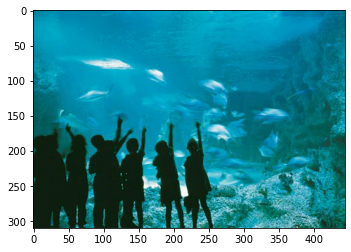

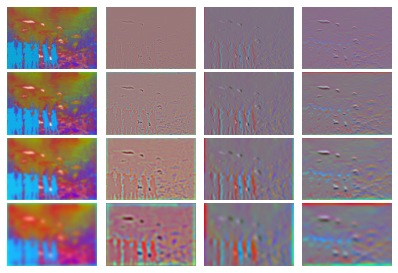

In [5]:
# Should have filters for at least 3 scales.
## Q-> 1.1.2

opts.filter_scales = [1, 2, 4, 8]  ## default
img_path = join(opts.data_dir, 'aquarium/sun_aztvjgubyrgvirup.jpg')
img = plt.imread(img_path) / 255.
plt.imshow(img)
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

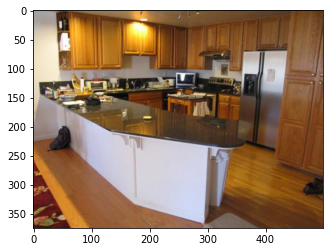

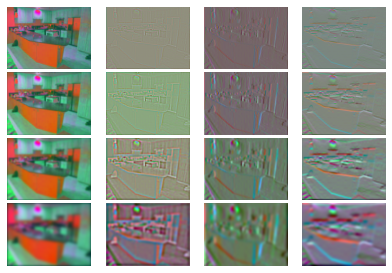

In [6]:
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
plt.imshow(img)
filter_responses = extract_filter_responses(opts, img)
display_filter_responses(opts, filter_responses)

## Q1.2

In [7]:
def compute_dictionary_one_image(args):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """
    opts, idx, img_path = args
    impath = opts.data_dir+'/'+img_path
    im = np.asarray(Image.open(impath))
    f_resp = extract_filter_responses(opts, im)
    shape = np.shape(f_resp)
    row = shape[0]
    col = shape[1]
    x = np.arange(row*col)
    np.random.shuffle(x)
    pix = x[0:opts.alpha]
    index = []
    for i in pix:
        x = i//col
        y = (i%col)-1
        if y==-1:
            x = x-1
            y = col-1
        index.append((x,y))
    alpix = np.zeros((opts.alpha,shape[2]))
    for i,(j,k) in enumerate(index):
        alpix[i] = f_resp[j,k,:]
    
    if not os.path.isdir('tempo'):
        os.mkdir('tempo')
    
    np.save("tempo/"+str(idx)+ ".npy",alpix)
    
    
def compute_dictionary(opts, n_worker=1):
    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    data_dir = opts.data_dir
    feat_dir = opts.feat_dir
    out_dir = opts.out_dir
    K = opts.K
    
    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    
    # ----- TODO -----
    #####Proc = []
    #####for i in range(2):
        #print(train_files[i])
        #p = multiprocessing.Process(target = compute_dictionary_one_image, args = [[opts,i,train_files[i]]])
        #p.start()
        #Proc.append(p)
        
    #for pro in Proc:
        #pro.join()
    ###############################################################################################################    
        
    for i in range(len(train_files)):
        ## print(i,train_files[i])
        compute_dictionary_one_image([opts,i,train_files[i]])
    print("Computing Dictionary Done")
    
    fr = []
    for i in range(len(train_files)):
        fl = 'tempo/'+str(i)+'.npy'
        dat = np.load(fl)
        fr.append(dat)
    #print(np.shape(fr))
    
    fr = np.concatenate(fr,axis=0)
        ## print(np.shape(fr))
    kmeans = KMeans(n_clusters = opts.K).fit(fr)
    dictionary = kmeans.cluster_centers_   
        ### print(np.shape(dictionary))   #(10, 48)
    np.save('./dictionary.npy', dictionary)

In [8]:
n_cpu = get_num_CPU()
compute_dictionary(opts, n_worker=n_cpu)
#compute_dictionary_one_image([opts,n_cpu,"aquarium/sun_asgtepdmsxsrqqvy.jpg"])

Computing Dictionary Done


## Q1.3

The wordmap shows the contours in each image. Words change along the edges and tend to stay the same for homogenous regions.

In [9]:
def get_visual_words(opts, img, dictionary):
    """
    Compute visual words mapping for the given img using the dictionary of visual words.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    """

    # ----- TODO -----
    #print(img)
    
    fr = extract_filter_responses(opts, img)
    row,col,depth = np.shape(fr)
    #dist = scipy.spatial.distance.cdist(dictionary, fr, metric='euclidean')
    #print(row,col,depth)
    fr = np.reshape(fr, [row*col, depth])
    #print(np.shape(fr))
    # ----- TODO -----
    
    # YOUR CODE HERE
    #dist1 = filter_responses#.reshape(3,-1)
    distances = scipy.spatial.distance.cdist(fr, dictionary, metric='euclidean')
    wordmap = np.argmin(distances, axis = 1)
    wordmap = wordmap.reshape(img.shape[0], img.shape[1])
    
    return wordmap


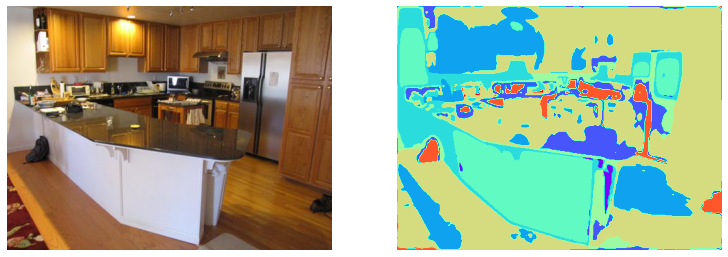

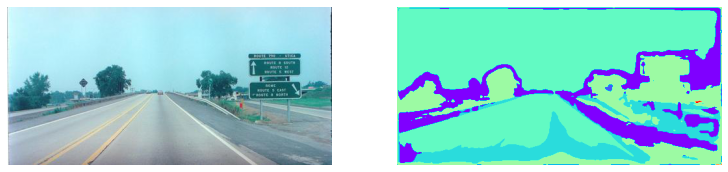

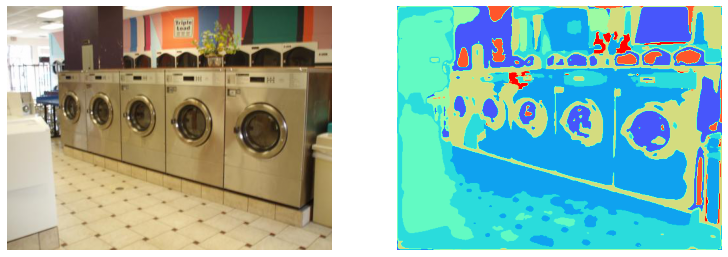

In [10]:
dictionary = np.load('./dictionary.npy')
#print(np.shape(dictionary)) 

img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'highway/sun_ailjxpgyepocjdos.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'laundromat/sun_aabvooxzwmzzvwds.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

The word boundaries in the above figure make a lot of sense. It can be seen trying to group similar words - created using features it detects after running the filter-bank over the images (alpha points each) - together and creating a distinction between them. Same colors each are one of the words from the opts.K number of features we find and save in dictionary.npy.

One can easily see from the above pictures how it gives a decent estimate for us to make sense of image and classify.

## Q2.1

In [11]:
def get_feature_from_wordmap(opts, wordmap):
    '''
    Compute histogram of visual words.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist: numpy.ndarray of shape (K)
    '''

    K = opts.K
    # ----- TODO -----
    bins_start_end = np.arange(K+1)
    hist,b = np.histogram(wordmap,bins=bins_start_end,density = True)
    
    
    #print(hist,b)
    #print(hist/sum(hist))
    #print(np.sum(hist),len(wordmap.flatten()))
    #print(sum(hist))
    #plt.bar(bins_start_end[:-1], hist, width = 1)
    
    return hist

Sample


<BarContainer object of 10 artists>

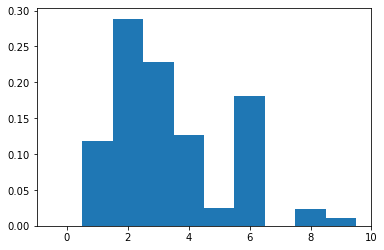

In [12]:
print("Sample")
hist = get_feature_from_wordmap(opts, wordmap)
    ### print(np.sum(hist))  -- total 1 as it is normalised
bins_start_end = np.arange(opts.K+1)
plt.bar(bins_start_end[:-1], hist, width = 1)

## Q2.2



In [13]:
def get_feature_from_wordmap_SPM(opts, wordmap):
    """
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist_all: numpy.ndarray of shape (K*(4^L-1)/3)
    """

    K = opts.K
    L = opts.L
    H, W = np.shape(wordmap)
    # ----- TODO -----
    
    l = np.asarray(list(reversed(range(L+1))))+1  #wts are in opposite order
    l[0]=l[1]
    wts = (1/2)**l 
    
    ###############################################################################################################
    
    mx = 2**L
    ot = []
    for l in range(L, -1, -1):
        ot_new=[]
        hist_new=[]
        idx = 2**l
        patch_y = W//idx
        patch_x = H//idx
        stride = (2**L)//idx #defines movement like in CNN
        
        if l == L:
            hist_temp = np.zeros((mx, mx, K))
            for i in range(mx):
                for j in range(mx):
                    pix = wordmap[i*patch_x: (i+1)*patch_x, j*patch_y : (j+1)*patch_y ]
                    hist = get_feature_from_wordmap(opts, pix)
                    #print(np.shape(hist))
                    hist_temp[i,j,:] = hist
                    ot = np.hstack([ot, hist*wts[l]])
        else:
            for i in range(idx):
                for j in range(idx):
                    hist_new = np.concatenate((hist_temp[stride*i:stride*(i+1),stride*j:stride*(j+1),: ]))
                    hist_new = np.sum(hist_new, axis = 0)
                    
                    ot_new = np.hstack([ot_new, hist_new*wts[l]])
                    
        ot= np.hstack([ot_new, ot])
    
    hist_all = ot
    #print(hist_all)
    hist_all = hist_all/np.sum(hist_all)
    ## print(np.shape(hist_all))
    
    return hist_all
    
#get_feature_from_wordmap_SPM(opts, wordmap)

## Q2.3

In [14]:
def distance_to_set(word_hist, histograms):
    #word_hist, histograms
    """
    Compute the distance between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * dists: numpy.ndarray of shape (N)
    """
    ###x = [0.2,0.3,0.5]
    ###y = [[0.2,0.3,0.5],[0.5,0.3,0.2]]

    # ----- TODO -----
    ####sim_try = np.minimum(x, y)
    ####sim_try = np.sum(sim_try,axis=1)
    ####print(sim_try)
    
    
    sim = np.minimum(word_hist, histograms)
    sim = np.sum(sim,axis=1)
    
    
    #### dist = 1/sim
    #### number of rows = histograms'
    
    return sim
# distance_to_set()

## Q2.4

In [15]:
def get_image_feature(opts, img_path, dictionary):
    """
    Extracts the spatial pyramid matching feature.

    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)


    [output]
    * feature: numpy.ndarray of shape (K)
    """
    K = opts.K
    # ----- TODO -----
    img = plt.imread(img_path)/255.0
    
    #print(img)
    ##print(np.shape(img))
    
    wordmap = get_visual_words(opts, img, dictionary)
    feature = get_feature_from_wordmap_SPM(opts, wordmap)

    return feature

In [16]:
def build_recognition_system(opts, n_worker=1):
    """
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir
    SPM_layer_num = opts.L

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
    dictionary = np.load(join(out_dir, "dictionary.npy"))
    
    ##print(np.shape(dictionary))
    ##feature = get_image_feature(opts, img_path, dictionary) #spatial pyramids received 
    ##print(np.shape(feature)) #layer = 1, thus - (4+1)*10 = 50
    ##print(np.shape(train_files)) ## all files of tempo
    ## ----- TODO -----
    
    ###############################################################################################################
    features = []
    
    #print(img_path)
    #print(train_files)
    #img_paths = data_dir + train_files
    #for i in range(train_labels): # -- for testing purposes
    
    
    for i in range(len(train_labels)):
        img_path = data_dir+"/"+train_files[i]
        ### print(i,img_path)
        f = get_image_feature(opts, img_path, dictionary)
        features.append(f)
    print("Getting Features Done")
    
    ##print(features[1])
    ##print(np.shape(features))
    ###############################################################################################################

    # example code snippet to save the learned system
    np.savez_compressed(join(out_dir, 'trained_system.npz'),
         features=features,
         labels=train_labels,
         dictionary=dictionary,
         SPM_layer_num=SPM_layer_num, )
    
    

In [17]:
build_recognition_system(opts, n_worker=n_cpu)

Getting Features Done


## Q2.5

In [18]:
def test_label_generation(opts, L, dictionary, trained_features, trained_labels, img_path):
    K = opts.K
    test_feature = get_image_feature(opts, img_path, dictionary)
    similarity = distance_to_set(test_feature, trained_features)
    idx = np.argmax(similarity) ### index to nearest image
    pred_label = trained_labels[idx]
    return pred_label

In [19]:
def evaluate_recognition_system(opts, n_worker=1):
    """
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    trained_features = trained_system['features']
    trained_labels = trained_system['labels']
    dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]

    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32) #true answers
    

    # ----- TODO -----
    #print(np.shape(test_files)) -- 400 image
    #print(test_files[0],test_labels[0])
    
    ###################################################################################################################
    
    
    predictions = []
    for i in range(len(test_labels)):
        img_path = data_dir+"/"+test_files[i]
        pred = test_label_generation(opts, test_opts.L, dictionary, trained_features, trained_labels, img_path)
        predictions.append(pred)
        ### print(i,img_path,pred)
    print("Predictions Done")
    
    conf = sklearn.metrics.confusion_matrix(test_labels,predictions) ##true in rows
    ## Conf[i,j] - no. of obs. known to be in i but classified as j
    
    accuracy = np.trace(conf)/np.sum(conf)

    return conf, accuracy
##evaluate_recognition_system(opts, n_worker=1)

In [20]:
conf, accuracy = evaluate_recognition_system(opts, n_worker=1)

Predictions Done


In [21]:
print("Accuracy:", accuracy)

Accuracy: 0.52


In [22]:
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]

df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,30,0,2,0,5,4,4,5
1,desert,0,24,6,10,3,1,3,3
2,highway,1,6,29,0,1,3,2,8
3,kitchen,1,3,1,33,10,2,0,0
4,laundromat,3,2,2,17,19,3,4,0
5,park,2,0,5,2,6,28,3,4
6,waterfall,7,1,1,0,7,9,24,1
7,windmill,2,5,7,1,3,5,6,21


In [23]:
print("Till now, everything with default values for opts (shown below)")
print(opts.K,opts.L,opts.alpha,opts.filter_scales)  ### Default Values

Till now, everything with default values for opts (shown below)
10 1 25 [1, 2, 4, 8]


## Q2.6



All true Observations are equal, i.e., 50 each taken from the 8 classes.

In [24]:
np.diag(conf) / np.sum(conf,axis =1)

array([0.6 , 0.48, 0.58, 0.66, 0.38, 0.56, 0.48, 0.42])

It can be seen that windmill, laundromat, waterfall and desert perform bad compared to others. The images in these classes have closely mapped and similar count of same features, hence, the Bag of words is failing to capture.

### Reason 1.
From the table above for instance, it can be seen that kitchen and laundromat are being misclassified as each other a lot. This might be because they have similar features in them and number of times these features repeat - leading to similar histograms. This will create problems in predictions. A sample of this is shown below.

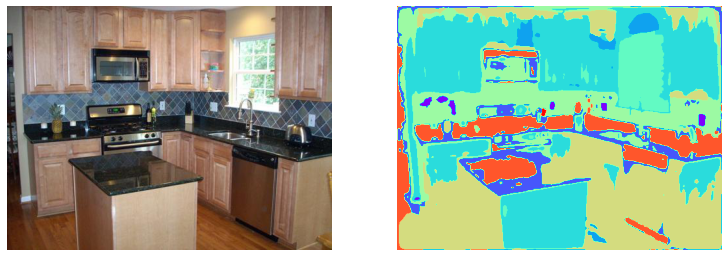

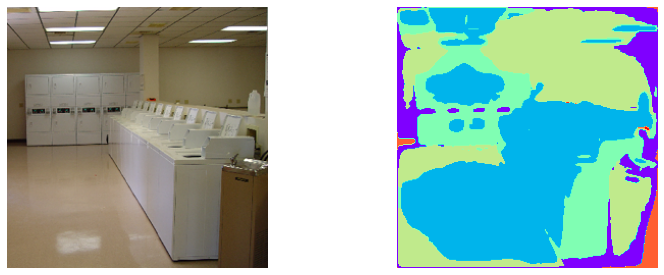

In [25]:
img_path = join(opts.data_dir, 'kitchen/sun_ajysozhvdlynojyx.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'laundromat/sun_apwwjlkltuoymnio.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

Despite being from two different classes, as it can be seen in blue, the responses have been similar to filter thereby creating similar histograms. This cause difficulty to the algorithm to classify them correctly.

### Reason 2. 
Another reason also includes humans and other objects present in the image. They block key regions that could have been essential to classify the pictures correctly. Hence, the low accuracy.

### 3. Example of error in our testing
##### # Highway misclassified as Windmill (our data above)

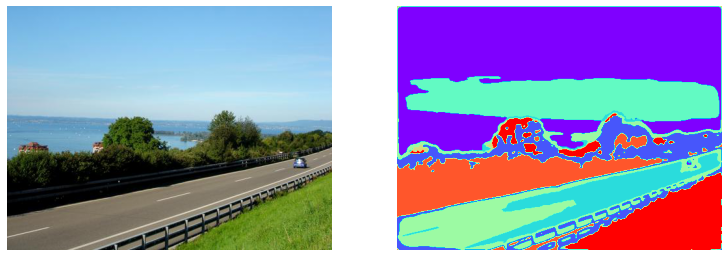

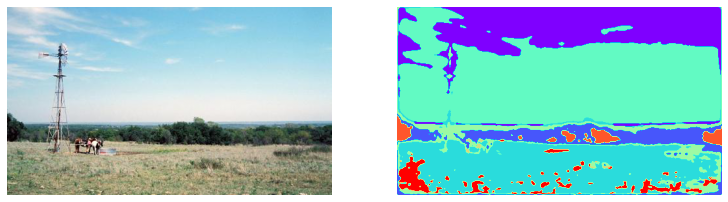

In [26]:
img_path = join(opts.data_dir, 'highway/sun_bmloawfqyzzgnvyb.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

img_path = join(opts.data_dir, 'windmill/sun_bxzsglbilsxviyio.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

##### Heavy similarity between the 2 dominant colors for the histograms. Presence of others is negligible.

#############################################################################################################################

## Q3.1



##### Hyperparameter tuning - followed by the table

In [27]:
opts.filter_scales = [1, 2, 4, 8, 16]
opts.K = 100
opts.alpha = 150
opts.L = 3

#changing from default to better values of parameters - better accuracy achieved
print(opts.K,opts.L,opts.alpha,opts.filter_scales)  ### Improved Values for opts

100 3 150 [1, 2, 4, 8, 16]


In [28]:
compute_dictionary(opts, n_worker=n_cpu)

Computing Dictionary Done


In [29]:
dictionary = np.load('./dictionary.npy')
print(np.shape(dictionary))  ### K * number of filters extracted

(100, 60)


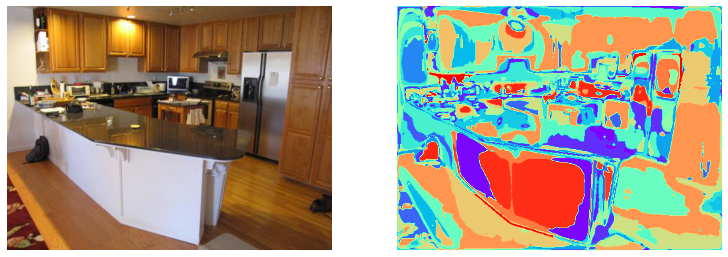

In [30]:
img_path = join(opts.data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = plt.imread(img_path) / 255.
wordmap = get_visual_words(opts, img, dictionary)
visualize_wordmap(img, wordmap)

In [31]:
build_recognition_system(opts, n_worker=n_cpu)

Getting Features Done


In [32]:
conf, accuracy = evaluate_recognition_system(opts, n_worker=n_cpu)

classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]

Predictions Done


In [33]:
print("Accuracy:", accuracy)

df = pd.DataFrame(conf, columns=classes)
df.insert(0, "", classes)
df

Accuracy: 0.6425


,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,39,1,0,1,3,2,0,4
1,desert,1,36,3,2,1,2,1,4
2,highway,1,4,28,0,0,4,2,11
3,kitchen,1,4,0,34,8,1,0,2
4,laundromat,1,2,1,8,30,5,3,0
5,park,1,0,6,2,1,35,2,3
6,waterfall,6,1,3,0,3,8,27,2
7,windmill,1,4,13,0,0,4,0,28


### THe table explaining how I tuned parameters to increase accuracy -

#1. alpha = 25, L = 1, K = 10, feature_scales = 4 ([1,2,4,8]) -------------------------- Accuracy = 52% (Default)
#2. alpha = 50, L = 1, K = 10, feature_scales = 4 ([1,2,4,8]) -------------------------- Accuracy = 53.5%
#3. alpha = 50, L = 2, K = 10, feature_scales = 4 ([1,2,4,8]) -------------------------- Accuracy = 53.5%
#4. alpha = 50, L = 2, K = 20, feature_scales = 4 ([1,2,4,8]) -------------------------- Accuracy = 58.5%
#5. alpha = 50, L = 2, K = 20, feature_scales = 5 ([1,2,4,8,8xSq.Root(2)]) -------------- Accuracy = 59.75%
#6. alpha = 75, L = 2, K = 30, feature_scales = 5 ([1,2,4,8,8xSq.Root(2)]) ---------- Accuracy = 63%
#7. alpha = 100, L = 2, K = 40, feature_scales = 5 ([1,2,4,8,8xSq.Root(2)]) --------- Accuracy = 63.5%
#8. alpha = 100, L = 3, K = 40, feature_scales = 5 ([1,2,4,8,8xSq.Root(2)]) --------- Accuracy = 65%
#9. alpha = 100, L = 3, K = 50, feature_scales = 5 ([1,2,4,8,8xSq.Root(2)]) --------- Accuracy = 64%
#10. alpha = 150, L = 3, K = 100, feature_scales = 5 ([1,2,4,8,16]) ----------------- Accuracy = 64.25%  (Final)

##############################################################################

##### 1. Between #3 and #4 above,

increasing opts.K or number of KMeans' clusters from 10 to 20 helps us identify more number of features. More unique features and their counts in the image help increase the accuracy by 5% (to 58.5%).

##### 2. Between #4 and #5 above, 

increasing the feature scale from 4 to 5, helps understand the region of interest better. It describes the alpha points taken in the image further more, helping the algorithm to reach accuracy of 59.75% (1.25% increase)

##### 3. Between #5 and #6 above, 

when alpha is increased from 50 to 75 and K is increased from 20 to 30, the accuracy jumps over 3% to 63%.

##### ---> Increasing alpha increases our probability to find meaningful points in the image that contribute as information for the model to learn. Hence, it is expected increasing alpha will help the model (shown above).

##### ---> Increasing the L may help understand the regions inside the image better. Though they may have similar features in the image, their placing in the image might also carry significant information. (like blue below might indicate water, whereas in the upper region of the image will signify sky).

##### ---> Increasing KMeans' cluster count we are trying to find more unique features from the information filters provide. This helps the algorithm understand the differences between classes better.

These are not ever-increasing values. They need to be optimised for best performance else, the accuracy may start failing with overfitting as well.

# Q3.2

### Run the cells below for increased accuracy

### There are several ways where we can improve the accuracy of the system. 

#1. We take random alpha points. But there are chances we end up taking points that are not edges, corners or any such points of interest that provide us valueable information. Instead, we could use image pre-processing to find important points and also use Hog or SIFT to store descriptors about those regions. This will provide more information to the model.

#2. Support Vector Machines can be used for better classification results (with Gaussian (X^2) Kernel). This has higher accuracy. (deployed below)
(https://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)

(https://www.youtube.com/watch?v=iGZpJZhqEME 26:57 onwards)

#3. A computationally efficient representation - relative spatial information between visual words; and use a soft pairwise voting scheme based on the distance in the descriptor space.
##### citation - (Khan, Rahat, et al. "Spatial histograms of soft pairwise similar patches to improve the bag-of-visual-words model." Computer Vision and Image Understanding 132 (2015): 102-112.)

#4. Use GPUs for faster implementation. (Tried multiprocessing but it didn't work for me).

##### Suggestion 2 above - SVC (gaussian Kernel) ----> Deployed below to increase accuracy

##### 1. What I did ?
I took the training features created by getting the filter responses and making the spacial pyramid histogram. This training data of size [ N by K*(4^(L+1) - 1)/3 ] is provided to the Support Vector Classifier to create boundary amongst the 8 classes of images we have. Kernel is set to 'RBF' (or gaussian - based on euclidean distance). Regularisation parameter is tested and the best result is kept. It is to increase the accuracy even after hyperparameter tuning has increased it to over 65%.

##### 2. What I expected ?
I expected the Classifier to perform better than just the similarity method deployed previously as kernels in SVM help seperating and classifying data better. I expected the data to be non-linearly seperable and hence, (after reading the above cited paper) decided to deploy the rbf kernel.

##### 3 What actually happened ?
Iterating over few regularisation parameter values, SVC proved to give significantly better results than the similarity method used previously. The accuracy percentge went beyond 70%.

In [34]:
### svm implementation. (Number - 2 suggestion above)

def SVM_test(opts, n_worker = 1):
    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    trained_features = trained_system['features']
    trained_labels = trained_system['labels']
    dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]
    
    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32) #true answers
    
    clf_p =  SVC(C=100, kernel='rbf',gamma='scale')
    clf = make_pipeline(StandardScaler(),clf_p)
    ### gaussian/rbf kernel and scaled using variance as well. (penalising factor 1)
    clf.fit(trained_features, trained_labels)
    
    predictions = []
    for i in range(len(test_labels)):
        img_path = data_dir+"/"+test_files[i]
        test_feature = get_image_feature(opts, img_path, dictionary)
        #### print(np.shape(test_feature), np.shape(trained_features))
        pred_label = clf.predict([test_feature])
        predictions.append(pred_label[0])
        ## print(i,img_path,pred_label[0])
    print("Predictions Done")
    
    conf = sklearn.metrics.confusion_matrix(test_labels,predictions) ##true in rows
    ## Conf[i,j] - no. of obs. known to be in i but classified as j
    accuracy = np.trace(conf)/np.sum(conf)

    return conf, accuracy

In [35]:
conf_svm, accuracy_svm = SVM_test(opts, n_worker=n_cpu)

Predictions Done


In [36]:
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]

print("Accuracy:", accuracy_svm)

df = pd.DataFrame(conf_svm, columns=classes)
df.insert(0, "", classes)
df

Accuracy: 0.7125


,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,36,9,0,1,0,1,2,1
1,desert,0,43,1,1,1,0,1,3
2,highway,0,1,29,0,0,1,6,13
3,kitchen,0,5,0,37,6,0,2,0
4,laundromat,0,5,1,7,34,2,1,0
5,park,0,0,4,1,3,38,4,0
6,waterfall,3,4,0,0,2,4,36,1
7,windmill,3,8,3,0,1,2,1,32


### Higher Accuracy of 71.25% achieved with Support Vector Classifier. (C=100)
##### Tried different C values - to avoid over-fittig

## Q3.3 (Extra Credit)

### Applying IDF on te high accuracy we have received after tuning the parameters. This is to check if TF-IDF helps increase the accuracy any further.

In [37]:
def test_label_generation_IDF(opts, L, dictionary, trained_features_idf, trained_labels, img_path,idf1):
    K = opts.K
    test_feature = get_image_feature(opts, img_path, dictionary)
    test_feature_idf = idf1*test_feature
    similarity = distance_to_set(test_feature_idf, trained_features_idf)
    idx = np.argmax(similarity) ### index to nearest image
    pred_label = trained_labels[idx]
    return pred_label

In [38]:
def compute_IDF(opts,trained_features,n_worker=1):
    K = opts.K
    word_count = np.zeros((1,K)) ### size1xK
    ## in all training examples - shows the features no. of times it is not there in training examples
    
    #for i in range(10):
    for i in range(len(trained_features)):
        for j in range(K):
            if (trained_features[i][j]==0):
                word_count[0][j]=word_count[0][j]+1
        #print(trained_features[i][0:opts.K])
    d = len(trained_features)-word_count
    #print(d) ### itne words mein features w aaya hai
    idf = np.log(len(trained_features)/d)  ### harr document mein hai toh 0
    ### more docs it is present in, weigth goes down
    np.save('./idf.npy', idf)
    return idf

def evaluate_recognition_System_IDF(opts, n_worker=1):
    
    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system.npz"))
    trained_features = trained_system['features']
    trained_labels = trained_system['labels']
    dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
    test_opts = copy(opts)
    test_opts.K = dictionary.shape[0]
    test_opts.L = trained_system["SPM_layer_num"]

    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32) #true answers
    ### print((trained_features[0][0:10]))
    ### first 10 from the big picture
    
    idf = compute_IDF(opts,trained_features,n_worker=1) #1xK in size
    
    ###print(np.shape(trained_features[0]))
    ###print(np.shape(idf))
    
    idf1=[]
    for i in range(opts.L+1):
        for j in range(4**i):
            idf1.append(idf)
    idf1 = (np.squeeze(idf1)).flatten()  #created along full length of an image's histogram
    ###print(np.shape(idf1))
    
    trained_features_idf = idf1*trained_features  ### new weigthed features created.
    #### print(np.shape(trained_features_idf))  
    
    predictions = []
    for i in range(len(test_labels)):
        img_path = data_dir+"/"+test_files[i]
        pred = test_label_generation_IDF(opts, test_opts.L, dictionary, trained_features_idf, trained_labels, img_path,idf1)
        predictions.append(pred)
        #print(i,img_path,pred)
    print("Predictions Done")
    
    conf = sklearn.metrics.confusion_matrix(test_labels,predictions) ##true in rows
    ## Conf[i,j] - no. of obs. known to be in i but classified as j
    accuracy = np.trace(conf)/np.sum(conf)

    return conf, accuracy

In [39]:
conf_idf, accuracy_idf =evaluate_recognition_System_IDF(opts, n_worker=n_cpu)

Predictions Done


In [40]:
classes = [
    "aquarium", "desert", "highway", "kitchen",
    "laundromat", "park", "waterfall", "windmill",
]

print("Accuracy:", accuracy_idf)

df = pd.DataFrame(conf_idf, columns=classes)
df.insert(0, "", classes)
df

Accuracy: 0.6025


,,aquarium,desert,highway,kitchen,laundromat,park,waterfall,windmill
0,aquarium,43,0,0,1,0,1,1,4
1,desert,0,39,5,3,0,0,1,2
2,highway,3,1,22,0,0,3,4,17
3,kitchen,0,4,0,36,7,0,1,2
4,laundromat,0,11,1,12,19,2,4,1
5,park,1,2,6,2,0,32,0,7
6,waterfall,7,0,3,0,3,8,24,5
7,windmill,5,5,8,3,0,3,0,26


### The performance after using IDF - reduces the performance results.
##### It may be that common visual words that appear in multiple images are helpful in distinguishing between classes. They can be common and would be down weighted in tf-idf.
##### Also, maybe if the count of a certain word in an image is very very low, it will still be treated to be present in the document and thereby, reducing its weight. This may have caused problems to distinguish in images where it had high importance for distinction.